In [1]:
#Libraries includig keras, numpy and matplot etc
from sklearn.metrics import accuracy_score,confusion_matrix
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold

from skimage import io
from skimage.transform import rotate, warp, AffineTransform

import warnings
warnings.filterwarnings("ignore")


from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import os

from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Data generator for loading the images with data augmentation
data_generator = ImageDataGenerator(rescale=1./255)

# Load the images from the dataset folder
data = data_generator.flow_from_directory(
    "/content/drive/MyDrive/Emotion",

    target_size=(256, 256),  # Set the target size for the images
    class_mode='categorical',  # Set the class mode to categorical for one-hot encoding
    color_mode='grayscale'
)
# Print the class labels
print(data.class_indices)

Found 35 images belonging to 4 classes.
{'Angry': 0, 'Happy': 1, 'Neutral': 2, 'Suprise': 3}


In [4]:

# Create variables for augmented images and labels
augmented_images = []
augmented_labels = []

# Iterate through the data generator to duplicate and augment images
for batch in data:
    batch_images, batch_labels = batch

    # Perform data augmentation
    for _ in range(10):  # Duplicate and augment each image 10 times
        augmented_image = batch_images[0].copy()

        # Apply augmentation techniques
        random_affine = AffineTransform(
            scale=(1.0, 1.0),  # No scaling
            translation=(0, 0),  # No translation
            shear=np.random.uniform(-0.2, 0.2)  # Random shear between -0.2 and 0.2
        )
        augmented_image = warp(augmented_image, random_affine.inverse)

        # Append the augmented image and label
        augmented_images.append(augmented_image)
        augmented_labels.append(batch_labels[0])

    # Break the loop if the desired augmentation size is reached
    if len(augmented_images) >= 840:
        break

# Convert the lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Print the shape of the augmented images and labels arrays
print("Augmented Images shape:", augmented_images.shape)
print("Augmented Labels shape:", augmented_labels.shape)


Augmented Images shape: (840, 256, 256, 1)
Augmented Labels shape: (840, 4)


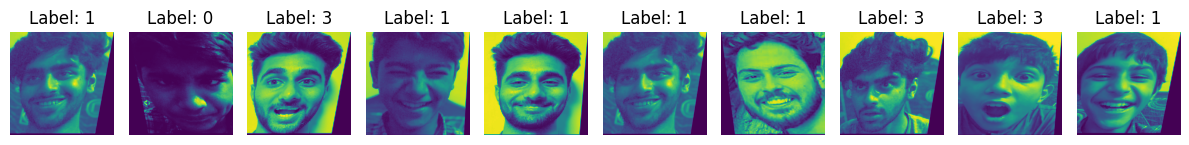

In [5]:
# Select a few random images from the dataset
num_images_to_plot = 10
random_indices = np.random.choice(len(augmented_images), num_images_to_plot, replace=False)
selected_images =  augmented_images[random_indices]
selected_labels =  augmented_labels[random_indices]

# Create a figure and subplot axes
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(12, 3))

# Plot the images with their labels
for i in range(num_images_to_plot):
    # Get the image and label
    image = selected_images[i]
    label = selected_labels[i]

    # Reverse the one-hot encoding to get the original label
    original_label = np.argmax(label)

    # Plot the image and display the label
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title("Label: {}".format(original_label))

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


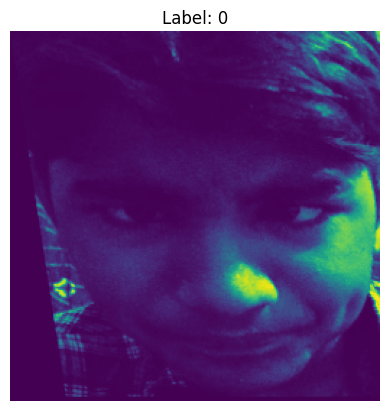

In [6]:
# Choose the index of the image you want to check
image_index = 30 # Change this to the desired image index

# Retrieve the image and its corresponding label
image = augmented_images[image_index]
label = augmented_labels[image_index]

# Reverse the one-hot encoding to get the original label
original_label = np.argmax(label)

# Display the image and its label
plt.imshow(image)
plt.axis('off')
plt.title("Label: {}".format(original_label))
plt.show()


In [7]:
# Load dataset and return train values
def load_dataset():
    # Reshape dataset to desired dimensions
    trainX = np.array(augmented_images)
    trainY = np.array(augmented_labels)

    return trainX, trainY


In [33]:
def train_and_evaluate_model(dataX, dataY, n_folds=10):
    train_accuracies = []
    val_accuracies = []

    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds)
    fold = 1  # Initialize fold counter
    # define model
    model = define_model()
    for train_ix, test_ix in kfold.split(dataX):

        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=50, validation_data=(testX, testY), verbose=1)

        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=1)
        print('> Fold %d: %.3f' % (fold, acc * 100.0))
        scores.append(acc)

        # Predict labels for train and test sets
        train_pred = model.predict(trainX)
        test_pred = model.predict(testX)

        # Calculate metrics for train and test sets
        train_acc = accuracy_score(np.argmax(trainY, axis=1), np.argmax(train_pred, axis=1))
        test_acc = accuracy_score(np.argmax(testY, axis=1), np.argmax(test_pred, axis=1))
        train_accuracies.append(train_acc)
        val_accuracies.append(test_acc)

        # Create confusion matrix for train and test sets
        train_cm = confusion_matrix(np.argmax(trainY, axis=1), np.argmax(train_pred, axis=1))
        test_cm = confusion_matrix(np.argmax(testY, axis=1), np.argmax(test_pred, axis=1))

        print("Train Accuracy: %.3f" % (train_acc * 100.0))
        print("Test Accuracy: %.3f" % (test_acc * 100.0))
        print("Train Confusion Matrix:")
        print(train_cm)
        print("Test Confusion Matrix:")
        print(test_cm)

        fold += 1

        histories.append(history)

    return scores, histories, n_folds, model,train_accuracies,val_accuracies


# plot diagnostic learning curves
def summarize_diagnostics(histories):
  for i in range(len(histories)):
    # plot loss
    pyplot.subplot(2, 1, 1)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(histories[i].history['loss'], color='blue', label='train')
    pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(2, 1, 1)
    pyplot.title('Classification Accuracy')
    pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
    pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
  pyplot.show()


# summarize model performance
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
  # box and whisker plots of results


In [25]:
def define_model():
    model = Sequential()
    model.add(Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(256, 256, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(4, activation='softmax'))

    opt = Adam(learning_rate=0.0000092650000000005)
    model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['accuracy'])


    return model


In [26]:
#loading dataset
trainX,trainY=load_dataset()

#Validating our model
scores, histories,folds,model,train_accuracies,val_accuracies = train_and_evaluate_model(trainX,trainY)


Epoch 1/10
16/16 [==============================] - 48s 3s/step - loss: 1.2040 - accuracy: 0.5119 - val_loss: 0.9593 - val_accuracy: 0.7857
Epoch 2/10
16/16 [==============================] - 44s 3s/step - loss: 0.8607 - accuracy: 0.7116 - val_loss: 0.6832 - val_accuracy: 0.7738
Epoch 3/10
16/16 [==============================] - 43s 3s/step - loss: 0.6492 - accuracy: 0.8108 - val_loss: 0.4724 - val_accuracy: 0.9643
Epoch 4/10
16/16 [==============================] - 44s 3s/step - loss: 0.5051 - accuracy: 0.8995 - val_loss: 0.3656 - val_accuracy: 0.9167
Epoch 5/10
16/16 [==============================] - 44s 3s/step - loss: 0.3936 - accuracy: 0.9458 - val_loss: 0.2876 - val_accuracy: 0.9762
Epoch 6/10
16/16 [==============================] - 46s 3s/step - loss: 0.3213 - accuracy: 0.9656 - val_loss: 0.2542 - val_accuracy: 0.9762
Epoch 7/10
16/16 [==============================] - 45s 3s/step - loss: 0.2744 - accuracy: 0.9577 - val_loss: 0.1830 - val_accuracy: 0.9881
Epoch 8/10
16/16 [==

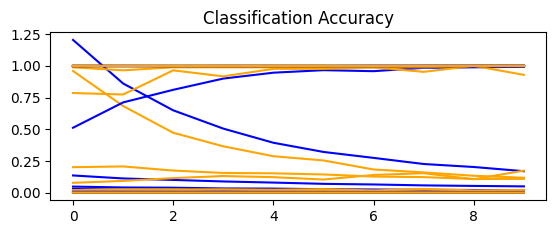

Train Result
Accuracy: mean=99.960 std=0.119, n=10
Test Result
Accuracy: mean=99.286 std=2.143, n=10


In [34]:
summarize_diagnostics(histories)
print("Train Result")
summarize_performance(train_accuracies)
print("Test Result")
summarize_performance(val_accuracies)

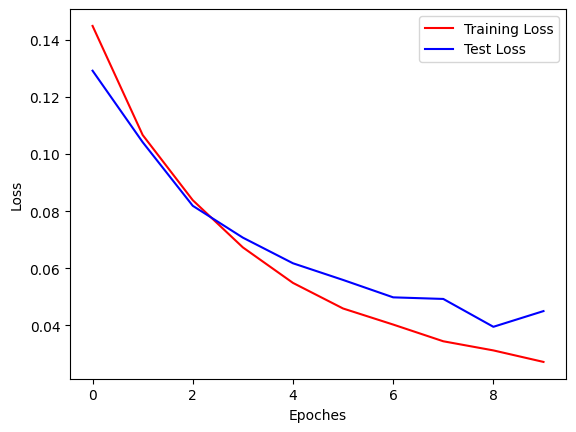

In [35]:
#Validaton and train graphfinal
Totalloss=int(len(histories[0].history['loss']))
avg_loss=np.zeros(Totalloss)
avg_val_loss=np.zeros(Totalloss)
for i in range(folds):
  avg_loss=np.add(avg_loss,histories[i].history['loss'])
  avg_val_loss = np.add(histories[i].history['val_loss'],avg_val_loss)

avg_loss=avg_loss/folds
avg_val_loss=avg_val_loss/folds

plt.plot(avg_loss[:],c='r')
plt.plot(avg_val_loss[:],c='b')
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.legend(["Training Loss","Test Loss"])
plt.show()

In [36]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [38]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image



In [46]:
import cv2

# Define the class labels
class_labels = {0: "Angry", 1: "Happy", 2: "Neutral",3:"Suprise"}

# Preprocess the input image
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256))
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=-1)
    return image

# Prediction function
def predict_class(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)

    # Make a prediction using the model
    prediction = model.predict(np.array([image]))
    predicted_class = np.argmax(prediction)

    # Get the predicted class label
    label = class_labels[predicted_class]

    return label

# Example usage
image_path = filename
predicted_label = predict_class(image_path)
print("Predicted Label:", predicted_label)


1/1 [==============================] - 0s 55ms/step
Predicted Label: Neutral
